In [350]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_call_price

from data import DataFromFolder
from utils import call_payoff, stochastic_integral
from models import ControlNet, EnsembleNet
from train import train_val
from evaluation import get_eval_data
from risk_measures import median_loss

import yfinance as yf
from arch import arch_model
import dask.dataframe as dd

from tqdm import tqdm, trange

from typing import Callable, Optional
import multiprocessing
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

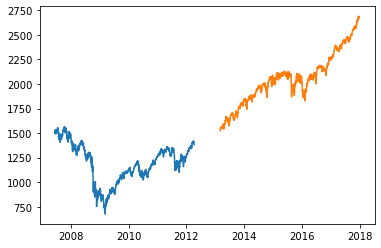

In [351]:
ticker = yf.Ticker('^GSPC')
hist_v1 = ticker.history(start='2013-03-04', end='2018-01-02').Close
hist_v2 = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist_v2);
plt.plot(hist_v1)

In [352]:
# From fitting the GARCH model using R get following parameters

SIGMA_V1 = 0.0643661
SIGMA_V2 = 0.1221684

MU_V1 = 0.048758
MU_V2 = 0.056105

SQRT_252 = 252 ** 0.5

In [353]:
h_params = {"N_SIM": None,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

## V1: Simulation example

In [354]:
initial_value = hist_v1.iloc[0]
strike = initial_value
n_steps = 50
price = bs_call_price(n_steps, initial_value, SIGMA_V1, h_params["RF"], strike)
initial_value, strike, SIGMA_V1, price

(1525.199951171875, 1525.199951171875, 0.0643661, 14.495137664357117)

In [355]:
# files = os.listdir('v1')
# h_params["N_SIM"] = sorted([int("".join([s for s in txt if s.isdigit()])) for txt in files])[-1]
# print(f'Number of batches: {h_params["N_SIM"]}')

In [356]:
df_shape = pd.read_parquet('v1/gjrpath1.parquet').shape
h_params["BATCH_SIZE"] = df_shape[1]
df_shape

(50, 256)

In [357]:
dt = DataFromFolder("v1/", price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA_V1, mu_const=MU_V1, take_log=True)

In [358]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 2, [20, 20], 1, learn_price=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:32<00:00, 10.37batch/s, loss=306, metric=50.1]


validation loss: 7615.508447265625


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:31<00:00, 10.60batch/s, loss=189, metric=31.8]


validation loss: 29069.05009765625


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:31<00:00, 10.73batch/s, loss=304, metric=56.7]


validation loss: 1380.848324584961


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:31<00:00, 10.42batch/s, loss=239, metric=41.7]


validation loss: 751.0408615112304


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:31<00:00, 10.62batch/s, loss=731, metric=51.8]


validation loss: 12874.102099609376


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:32<00:00, 10.10batch/s, loss=211, metric=49]


validation loss: 5672.329431152344


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:31<00:00, 10.71batch/s, loss=210, metric=47.4]

CPU times: user 18min 36s, sys: 3min 43s, total: 22min 20s
Wall time: 15min 52s


### Delta Hedging Benchmark

In [359]:
# Delta hedging benchmark
# Does this make sense with constant vola???
# n_steps not constant!!! I think we had this wrong the entire project!!

# Cython code based on: https://github.com/JackJacquier/python-for-finance/blob/master/Session-7-Cython/Intro_to_Cython.ipynb

In [360]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [361]:
%%cython --compile-args=-O3
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef double gaussian_cdf(double x) nogil:
    return 0.5*(1+erf(x*ONE_OVER_SQRT_TWO))

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef cnp.ndarray[cnp.double_t, ndim=1] cython_bs_delta(cnp.ndarray[cnp.double_t, ndim=1] sigma, cnp.ndarray[cnp.double_t, ndim=1] S0,double K, cnp.ndarray[cnp.double_t, ndim=1] T):
    cdef int size=len(S0)
    cdef double k, d1, sigmaT
    cdef cnp.ndarray[cnp.double_t, ndim=1] result=np.zeros(size)
        
    with nogil:
        for i in range(size):
            sigmaT = sigma[i] * sqrt(T[i])
            k = log(S0[i] / K)
            d1 = k / sigmaT + 0.5*sigmaT
            result[i] = gaussian_cdf(d1)
        
    return result

In [362]:
# make index to pass decreasing time to maturity to the bs_delta function
idx = np.arange(n_steps) + 1
idx = idx[::-1]

In [363]:
def cython_d_hedge(x, vol):
    return cython_bs_delta(vol.numpy().astype(np.float64), torch.exp(x).numpy().astype(np.float64), strike, idx.astype(np.float64) *  ( 1 / 365))

In [364]:
def hedge_diff(x, x1, x_inc, payoff, price, vol, model=ens):

    # calculate delta hedge; assuming x is log price!
    d_hedge_list = [cython_d_hedge(a.squeeze(), b.squeeze()) for a, b in zip(x, vol)]
    si_delta = stochastic_integral(x_inc, torch.Tensor(d_hedge_list))
    diff_delta = (price.squeeze() + si_delta).float() - payoff.float()

    # calculating model hedge
    if model.learn_price:
        output, price = model(x, x1)
    else:
        output = model(x, x1)

    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()

    return diff, diff_delta

In [365]:
diffs, diffs_delta = [], []

for i in val_indices:
    
    x, x1, x_inc, payoff, price = dt[i]
    vol = dt.get_vol(i)
    
    diff, diff_delta = hedge_diff(x, x1, x_inc, payoff, price, vol)
    diffs.append(diff)
    diffs_delta.append(diff_delta)
    
d = torch.cat(diffs)
d_delta = torch.cat(diffs_delta)

In [366]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

print('Delta Hedge:')
print(f"RMSE {(d_delta ** 2).mean() ** 0.5}")
print(f"Using median {(d_delta ** 2).median() ** 0.5}")
print(f"Using mode {(d_delta ** 2).mode()[0] ** 0.5}")

Model:
RMSE 17.32305335998535
Using median 6.253887176513672
Using mode 1.6071319580078125
Delta Hedge:
RMSE 18.092449188232422
Using median 7.240653991699219
Using mode 0.10494232177734375


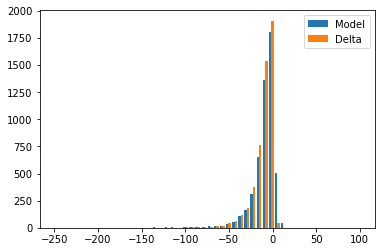

In [367]:
plt.hist([d.detach().numpy(), d_delta.detach().numpy()], range=(-250, 100), bins=50, label=['Model', 'Delta'])
plt.legend();

In [368]:
pd.Series(d_delta.detach()).describe()

count    5120.000000
mean      -11.209102
std        14.203241
min      -221.973099
25%       -14.602339
50%        -7.241053
75%        -3.001376
max         5.435819
dtype: float64

In [369]:
d_series = pd.Series(d.detach())
d_series.describe()

count    5120.000000
mean       -9.282535
std        14.627513
min      -200.542542
25%       -13.079313
50%        -5.770708
75%        -1.014028
max        15.422611
dtype: float64

## Real data example

In [24]:
initial_value = hist_v1.iloc[0]
dt = DataFromFolder("../input/gjr-vol/v2_2/v2/", price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA_V2, mu_const=MU_V2, take_log=True)

In [25]:
n_steps = 30
n_models = 1
models, optimizers, schedulers = [], [], []
n = 1000
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)
    
ens = EnsembleNet(models)

Epoch 0: 100%|██████████| 334/334 [00:35<00:00,  9.48batch/s, loss=72.3, metric=15.5]


validation loss: 2831.59814453125


Epoch 5: 100%|██████████| 334/334 [00:31<00:00, 10.44batch/s, loss=56.6, metric=8.98]


validation loss: 943.96962890625


Epoch 9: 100%|██████████| 334/334 [00:31<00:00, 10.47batch/s, loss=52.7, metric=7.2]


In [26]:
# Creating the validation paths

n_steps = 30
step = 5  # number of days by which to shift the window 
valid_paths, valid_prices, valid_strikes = [], [], []

for i in np.arange(start=0, stop=len(hist_v2) - n_steps, step=step):
    
    valid_path = hist_v2[i:i+n_steps+1]
    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=SIGMA_V2, rf=0, strike=S0)  # TODO: CORRECT SIGMA HERE    
    
    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [27]:
if dt.take_log:
    x = torch.log(valid_paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(x.squeeze(), strike=valid_strikes)

In [28]:
output = ens(x)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

In [29]:
d.shape

torch.Size([238])

In [30]:
print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")

Model:
RMSE 68.84994506835938
Using median 48.87608337402344


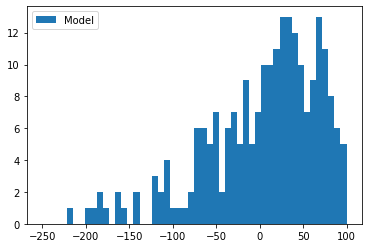

In [31]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

In [32]:
d_series = pd.Series(d.detach())
d_series.describe()

count    238.000000
mean       8.370173
std       68.483292
min     -218.341400
25%      -29.663028
50%       21.870682
75%       59.449477
max      134.072174
dtype: float64

In [33]:
# Sigma not correct yet that is used to caldulate the BS price
# Would also need that to implement delte hedging